In [1]:
from pathlib import Path
import pickle

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = "retina"

In [3]:
methods = {
    'sgd-rb-1': ('ogd', "olive", "dashdot"),
    'sgd-rb-10': ('r-sgd-10', plt.cm.Greens(0.9), "dashdot"),
    
    'adam-rb-1': ('r-adam-1', plt.cm.Reds(0.5), "--"),
    'adam-rb-10': ('r-adam-10', plt.cm.Reds(0.9), "--"),
    
    'fdekf': ('fdekf', 'black', "dotted"),
    'vdekf': ('vdekf', 'dimgray', "dotted"),
    
    'lofi-1': ('lofi-01', plt.cm.Blues(0.5), "-"),
    'lofi-10': ('lofi-10', plt.cm.Blues(0.9), "-"),
}

n_iter = 100

# Figure 2(a)

In [ ]:
# Set environmental variables
%env REBAYES_OUTPUT=./iid/f-mnist/mlp/nll
%env REBAYES_CONFIG=../configs/

# Run the script
# # To tune the hyperparameters:
# %run ../../run_regression_experiments.py \
#     --ranks 1 10 --dataset f-mnist --verbose 2 --model mlp --tune --ntrain 2000
%run ../../run_regression_experiments.py \
    --ranks 1 10 --dataset f-mnist --model mlp --n_iter 100 --ntrain 2000

In [4]:
path_fmnist_mlp = Path(Path.cwd(), "iid", "f-mnist", "mlp", "nll")

agents_fmnist_mlp = (
    *[f"sgd-rb-{rank}" for rank in [1, 10,]],
    *[f"adam-rb-{rank}" for rank in [10,]],
    "fdekf", "vdekf",
    *[f"lofi-{rank}" for rank in [1, 10,]],
)

results_rmse_fmnist_mlp, results_nll_fmnist_mlp = {}, {}

for method in agents_fmnist_mlp:
    with open(Path(path_fmnist_mlp, f'{method}.pkl'), "rb") as f:
        curr_result = pickle.load(f)
    
    results_rmse_fmnist_mlp[method] = {
        "mean": jnp.mean(curr_result["rmse"], axis=0),
        "std": jnp.std(curr_result["rmse"], axis=0),
    }
    results_nll_fmnist_mlp[method] = {
        "mean": jnp.mean(curr_result["nll"], axis=0),
        "std": jnp.std(curr_result["nll"], axis=0),
    }

In [5]:
def apply_convolve(x, kernel_size=20):
    left_pad = jnp.full(kernel_size // 2, x[0])
    right_pad = jnp.full(kernel_size // 2, x[-1])
    padded_data = jnp.concatenate([left_pad, x, right_pad])
    kernel = jnp.ones((kernel_size,)) / kernel_size
    smoothed = jnp.convolve(padded_data, kernel, mode='same')
    smoothed = smoothed[kernel_size//2:-kernel_size // 2]
    return smoothed

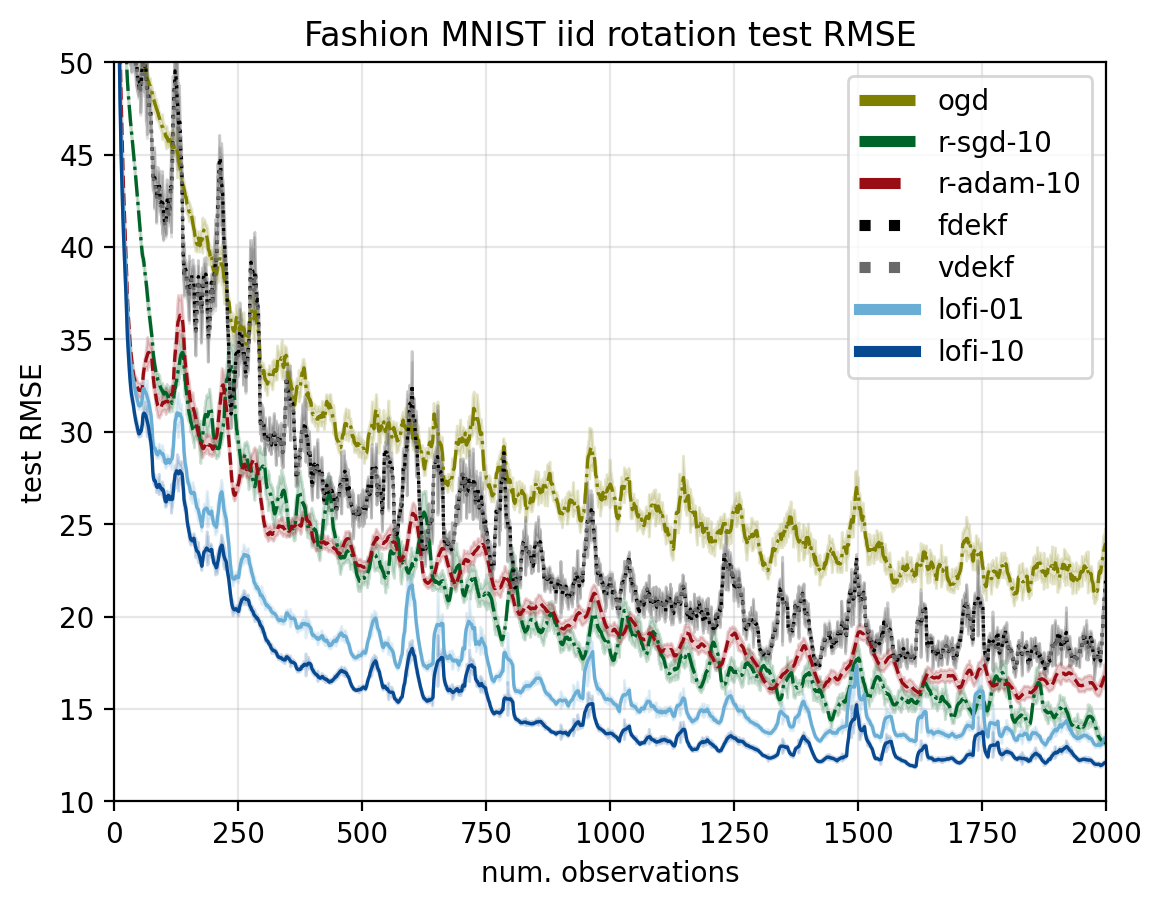

In [6]:
# RMSE
fig, ax = plt.subplots()
for key, val in results_rmse_fmnist_mlp.items():
    mean, std = apply_convolve(val['mean']), val['std']
    label, color, ls = methods[key]
    ax.plot(mean, label=label, c=color, linewidth=1.2, linestyle=ls)
    ax.fill_between(
        jnp.arange(mean.shape[0]),
        mean - std / jnp.sqrt(n_iter),
        mean + std / jnp.sqrt(n_iter),
        alpha=0.2,
        color=color
    )
ax.set_xlabel('num. observations')
ax.set_ylabel('test RMSE')
ax.set_xlim(0, 2_000)
ax.set_ylim(10, 50)
ax.grid(alpha=0.3)
ax.set_title('Fashion MNIST iid rotation test RMSE')
leg = ax.legend()
# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(4.0)

fig.savefig(Path(path_fmnist_mlp, 'fmnist-mlp-reg-test-rmse.pdf'), bbox_inches='tight')

# Figure 19(a)

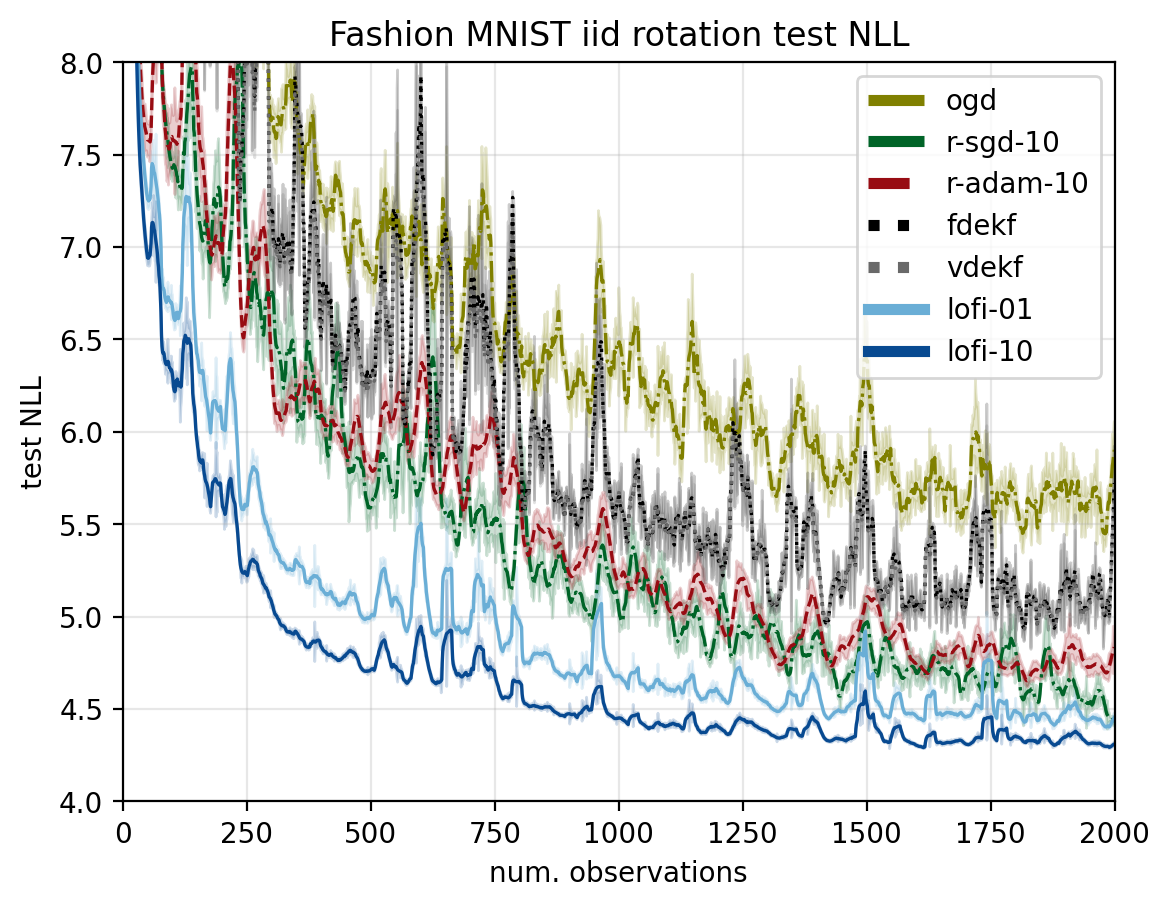

In [7]:
# NLL
fig, ax = plt.subplots()
for key, val in results_nll_fmnist_mlp.items():
    mean, std = apply_convolve(val['mean']), val['std']
    label, color, ls = methods[key]
    ax.plot(mean, label=label, c=color, linewidth=1.2, linestyle=ls)
    ax.fill_between(
        jnp.arange(mean.shape[0]),
        mean - std / jnp.sqrt(n_iter),
        mean + std / jnp.sqrt(n_iter),
        alpha=0.2,
        color=color
    )
ax.set_xlabel('num. observations')
ax.set_ylabel('test NLL')
ax.set_xlim(0, 2_000)
ax.set_ylim(4.0, 8.0)
ax.grid(alpha=0.3)
ax.set_title('Fashion MNIST iid rotation test NLL')
leg = ax.legend()
# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(4.0)

fig.savefig(Path(path_fmnist_mlp, 'fmnist-mlp-reg-test-nll.pdf'), bbox_inches='tight')

# Figure 19(b)

In [8]:
methods_nlpd = {
    'sgd-rb-1': ('ogd-laplace', "olive", "dashdot"),
    'sgd-rb-10': ('r-sgd-10-laplace', plt.cm.Greens(0.9), "dashdot"),
    
    'adam-rb-1': ('r-adam-1-laplace', plt.cm.Reds(0.5), "--"),
    'adam-rb-10': ('r-adam-10-laplace', plt.cm.Reds(0.9), "--"),
    
    'fdekf': ('fdekf', 'black', "dotted"),
    'vdekf': ('vdekf', 'dimgray', "dotted"),
    
    'lofi-1': ('lofi-01', plt.cm.Blues(0.5), "-"),
    'lofi-10': ('lofi-10', plt.cm.Blues(0.9), "-"),
}

n_iter = 100

In [ ]:
# Set environmental variables
%env REBAYES_OUTPUT=./iid/f-mnist/mlp/nlpd-mc
%env REBAYES_CONFIG=../configs/

# Run the script
# # To tune the hyperparameters:
# %run ../../run_regression_experiments.py \
#     --ranks 1 10 --dataset f-mnist --verbose 1 --model mlp --tune --ntrain 2000 \
#         --nll_method nlpd-mc --linearize
%run ../../run_regression_experiments.py \
    --n_iter 100 --ntrain 2000 --agents fdekf --nll_method nlpd-mc --linearize

In [10]:
path_fmnist_mlp_nlpd = Path(Path.cwd(), "iid", "f-mnist", "mlp", "nlpd-linearized")

agents_fmnist_mlp = (
    *[f"sgd-rb-{rank}" for rank in [1, 10,]],
    *[f"adam-rb-{rank}" for rank in [10,]],
    "fdekf", "vdekf",
    *[f"lofi-{rank}" for rank in [1, 10,]],
)

results_nlpd_fmnist_mlp = {}

for method in agents_fmnist_mlp:
    with open(Path(path_fmnist_mlp_nlpd, f'{method}.pkl'), "rb") as f:
        curr_result = pickle.load(f)
    results_nlpd_fmnist_mlp[method] = {
        "mean": jnp.mean(curr_result["nlpd"], axis=0),
        "std": jnp.std(curr_result["nlpd"], axis=0),
    }

In [11]:
def apply_convolve(x, kernel_size=20):
    left_pad = jnp.full(kernel_size // 2, x[0])
    right_pad = jnp.full(kernel_size // 2, x[-1])
    padded_data = jnp.concatenate([left_pad, x, right_pad])
    kernel = jnp.ones((kernel_size,)) / kernel_size
    smoothed = jnp.convolve(padded_data, kernel, mode='same')
    smoothed = smoothed[kernel_size//2:-kernel_size // 2]
    return smoothed

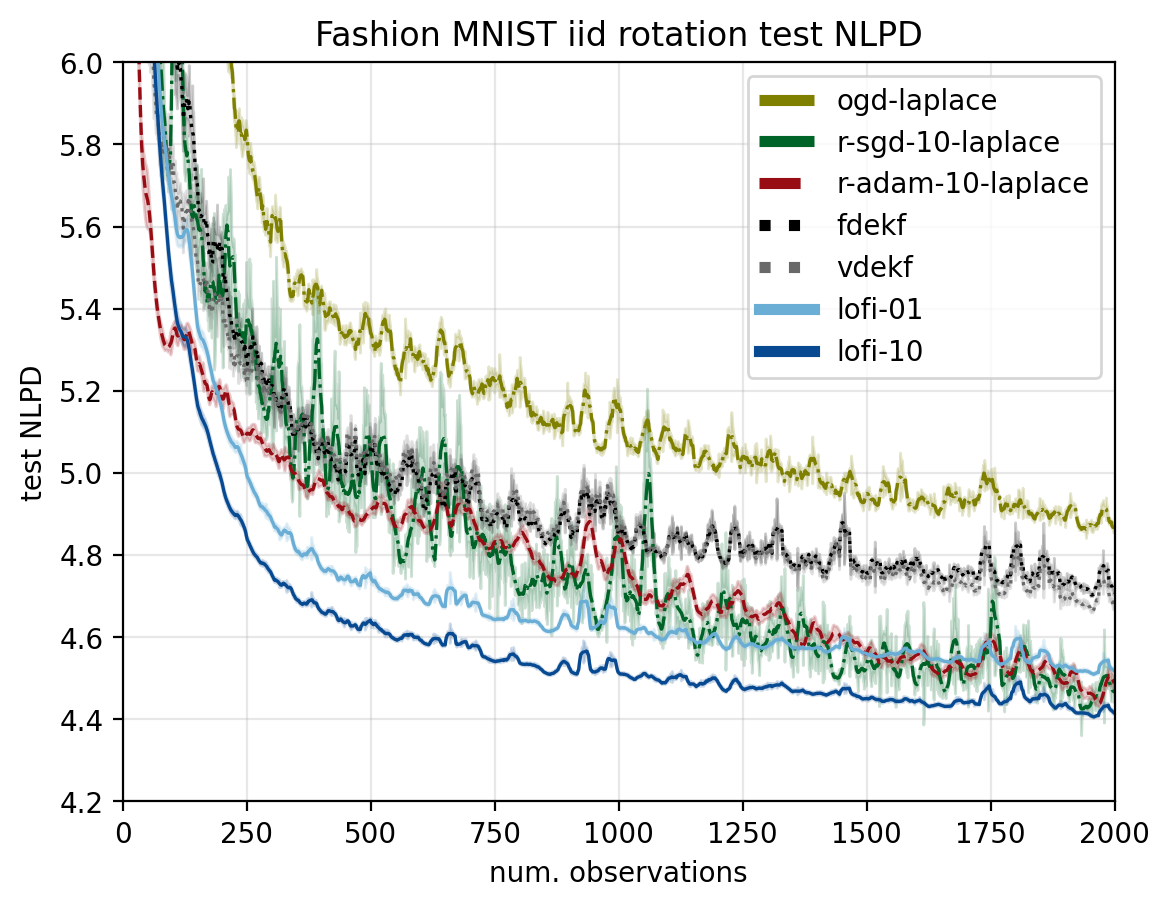

In [12]:
# NLPD-MC
fig, ax = plt.subplots()
for key, val in results_nlpd_fmnist_mlp.items():
    mean, std = apply_convolve(val['mean']), val['std']
    label, color, ls = methods_nlpd[key]
    ax.plot(mean, label=label, c=color, linewidth=1.2, linestyle=ls)
    ax.fill_between(
        jnp.arange(mean.shape[0]),
        mean - std / jnp.sqrt(n_iter),
        mean + std / jnp.sqrt(n_iter),
        alpha=0.2,
        color=color
    )
ax.set_xlabel('num. observations')
ax.set_ylabel('test NLPD')
ax.set_xlim(0, 2_000)
ax.set_ylim(4.2, 6.0)
ax.grid(alpha=0.3)
ax.set_title('Fashion MNIST iid rotation test NLPD')
leg = ax.legend()
# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(4.0)

fig.savefig(Path(path_fmnist_mlp_nlpd, 'fmnist-mlp-reg-test-nlpd.pdf'), bbox_inches='tight')

# Additional NLPD Experiments

 NLPD Temperature Comparison (Using NLL-tuned Hyperparams)

In [ ]:
# Set environmental va/run_regression_experiments.pyriables
%env REBAYES_OUTPUT=./iid-2000/f-mnist/mlp/nlpd-mc
%env REBAYES_CONFIG=../configs/

# Run the script
# To tune the hyperparameters:
%run run_regression_experiments.py --problem iid \
    --n_iter 20 --agents lofi --ranks 1 10 --temp 1.0 --nll_method nlpd-mc
%run run_regression_experiments.py --problem iid \
    --n_iter 20 --agents lofi --ranks 1 10 --temp 0.5 --nll_method nlpd-mc
%run run_regression_experiments.py --problem iid \
    --n_iter 20 --agents lofi --ranks 1 10 --temp 0.1 --nll_method nlpd-mc
%run run_regression_experiments.py --problem iid \
    --n_iter 20 --agents lofi --ranks 1 10 --temp 0.05 --nll_method nlpd-mc
%run run_regression_experiments.py --problem iid \
    --n_iter 20 --agents lofi --ranks 1 10 --temp 0.01 --nll_method nlpd-mc
%run run_regression_experiments.py --problem iid \
    --n_iter 20 --agents lofi --ranks 1 10 --temp 0.005 --nll_method nlpd-mc
%run run_regression_experiments.py --problem iid \
    --n_iter 20 --agents lofi --ranks 1 10 --temp 0.001 --nll_method nlpd-mc
%run run_regression_experiments.py --problem iid \
    --n_iter 20 --agents lofi --ranks 1 10 --temp 0.0005 --nll_method nlpd-mc
%run run_regression_experiments.py --problem iid \
    --n_iter 20 --agents lofi --ranks 1 10 --temp 0.0001 --nll_method nlpd-mc
%run run_regression_experiments.py --problem iid \
    --n_iter 20 --agents lofi --ranks 1 10 --temp 0.0 --nll_method nlpd-mc

In [35]:
methods_lofi_1 = {
    'lofi-1-temp-1.0': ('lofi-01-1.0', plt.cm.Blues(0.1), "-"),
    'lofi-1-temp-0.5': ('lofi-01-0.5', plt.cm.Blues(0.2), "-"),
    'lofi-1-temp-0.1': ('lofi-01-0.1', plt.cm.Blues(0.3), "-"),
    'lofi-1-temp-0.05': ('lofi-01-0.05', plt.cm.Blues(0.4), "-"),
    'lofi-1-temp-0.01': ('lofi-01-0.01', plt.cm.Blues(0.5), "-"),
    'lofi-1-temp-0.005': ('lofi-01-0.005', plt.cm.Blues(0.6), "-"),
    'lofi-1-temp-0.001': ('lofi-01-0.001', plt.cm.Blues(0.7), "-"),
    'lofi-1-temp-0.0005': ('lofi-01-0.0005', plt.cm.Blues(0.8), "-"),
    'lofi-1-temp-0.0001': ('lofi-01-0.0001', plt.cm.Blues(0.9), "-"),
    'lofi-1-temp-0.0': ('lofi-01-0.0', plt.cm.Blues(1.0), "-"),
}

n_iter = 20

In [72]:
path_fmnist_mlp_nlpd = Path(Path.cwd(), "iid-2000", "f-mnist", "mlp", "nlpd-mc-wo-tuning")

lofi_1_fmnist_mlp_nlpd = (
    *[f"lofi-1-temp-{temp}" for temp in ['1.0', '0.5', '0.1',
                                         '0.05', '0.01', '0.005',
                                         '0.001', '0.0005', '0.0001', '0.0']],
)

lofi_1_results_nlpd = {}
lofi_1_results_mean_nlpd = {}

for method in lofi_1_fmnist_mlp_nlpd:
    with open(Path(path_fmnist_mlp_nlpd, f'{method}.pkl'), "rb") as f:
        curr_result = pickle.load(f)

    key = "nlpd" if "nlpd" in curr_result else "nll"
    lofi_1_results_nlpd[method] = {
        "mean": jnp.mean(curr_result[key], axis=0),
        "std": jnp.std(curr_result[key], axis=0),
    }
    lofi_1_results_mean_nlpd[method.split("-")[-1]] = jnp.mean(curr_result[key])
        

In [55]:
kernel_size = 1
kernel = jnp.ones((kernel_size,)) / kernel_size
convolve = lambda x: jnp.convolve(x, kernel, mode='same')

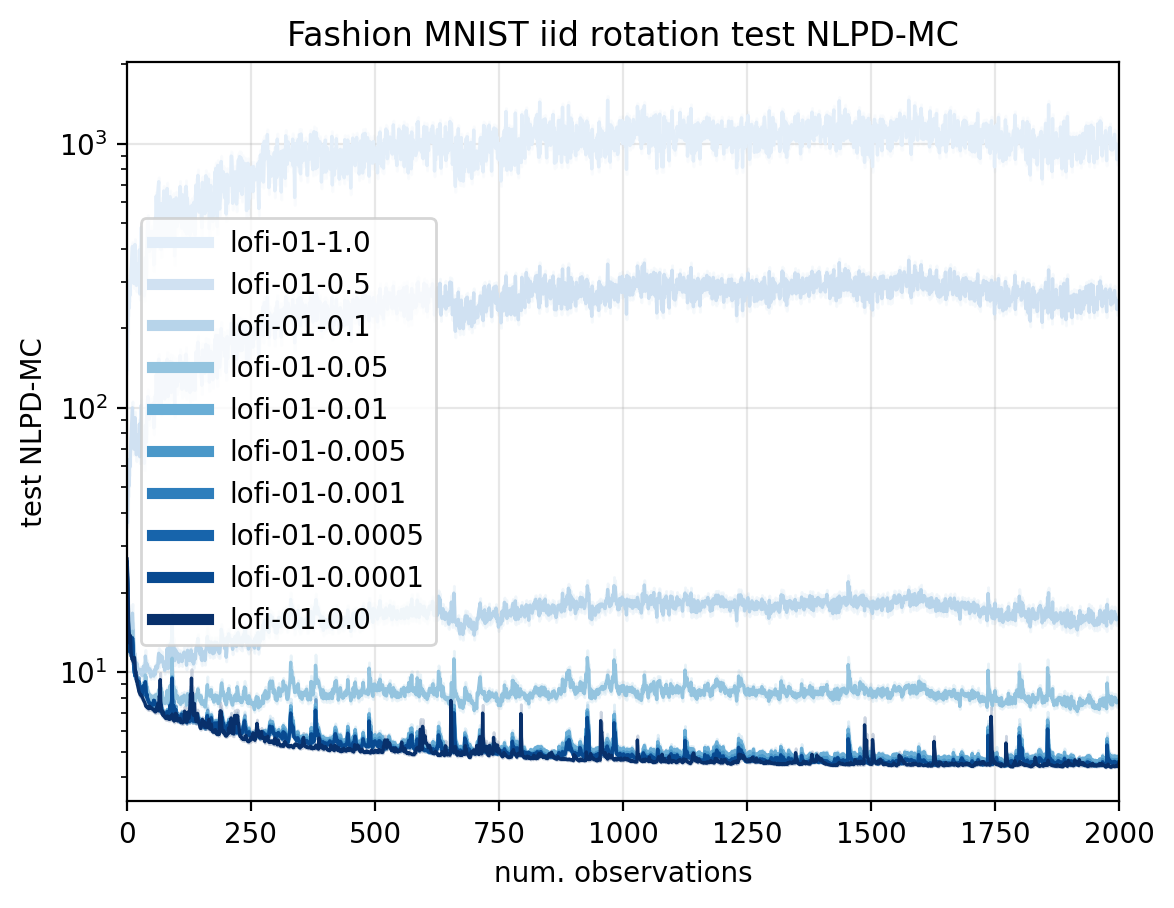

In [73]:
# NLPD-MC
fig, ax = plt.subplots()
for key, val in lofi_1_results_nlpd.items():
    mean, std = convolve(val['mean']), val['std']
    label, color, ls = methods_lofi_1[key]
    ax.plot(mean, label=label, c=color, linewidth=1.2, linestyle=ls)
    ax.fill_between(
        jnp.arange(mean.shape[0]),
        mean - std / jnp.sqrt(n_iter),
        mean + std / jnp.sqrt(n_iter),
        alpha=0.2,
        color=color
    )
ax.set_xlabel('num. observations')
ax.set_ylabel('test NLPD-MC')
ax.set_xlim(0, 2_000)
ax.set_yscale('log')
# ax.set_ylim(4.0, 20)
ax.grid(alpha=0.3)
ax.set_title('Fashion MNIST iid rotation test NLPD-MC')
leg = ax.legend()
# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(4.0)
# fig.savefig(Path(path_fmnist_mlp_nlpd, 'fmnist-mlp-reg-test-lofi1-nlpd-mc.pdf'), bbox_inches='tight')

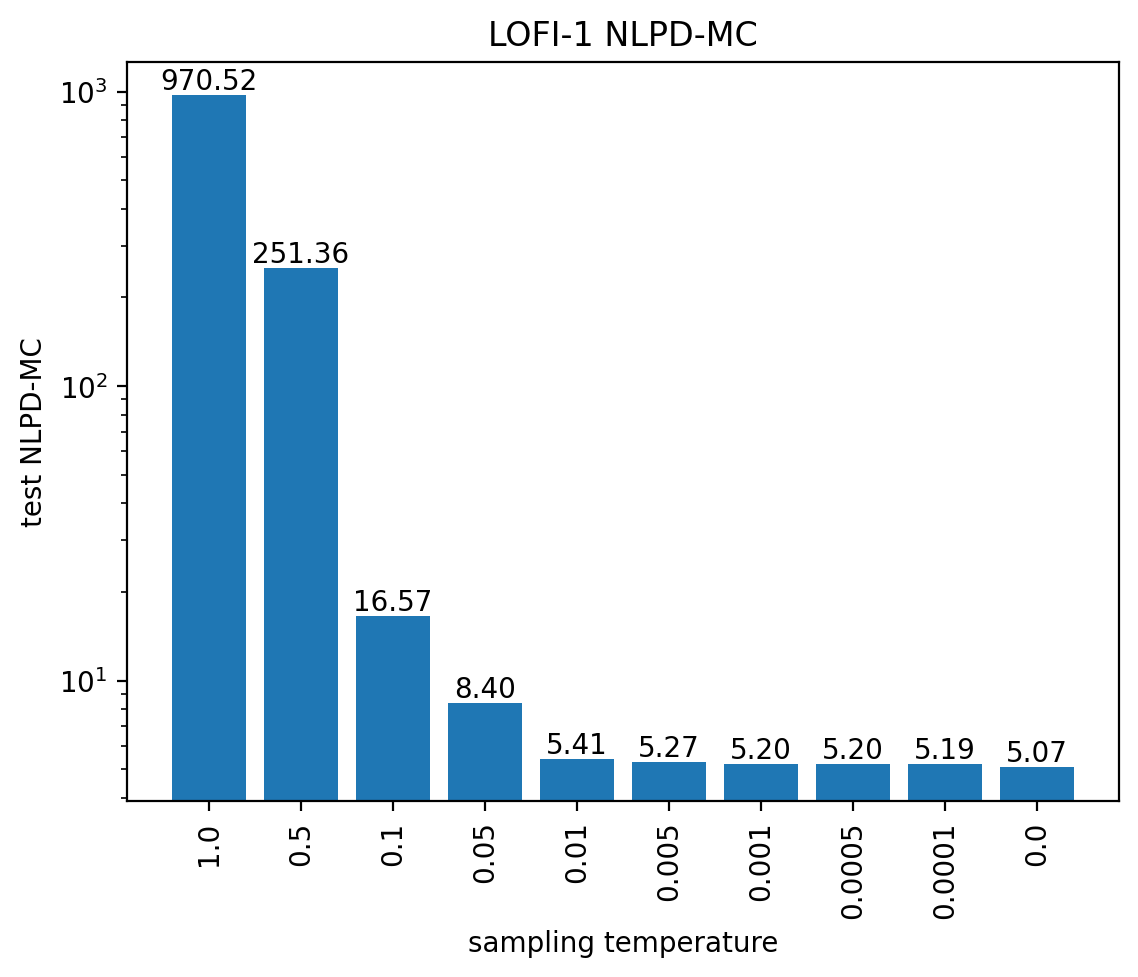

In [74]:
fig, ax = plt.subplots()
ax.bar(lofi_1_results_mean_nlpd.keys(), lofi_1_results_mean_nlpd.values());
ax.bar_label(ax.containers[0], fmt='%.2f', label_type='edge');
ax.set_yscale('log')
ax.set_ylabel('test NLPD-MC');
ax.set_xlabel('sampling temperature');
ax.set_title("LOFI-1 NLPD-MC")
plt.setp(ax.get_xticklabels(), fontsize=10, rotation='vertical');

In [40]:
methods_lofi_10 = {
    'lofi-10-temp-1.0': ('lofi-10-1.0', plt.cm.Blues(0.1), "-"),
    'lofi-10-temp-0.5': ('lofi-10-0.5', plt.cm.Blues(0.2), "-"),
    'lofi-10-temp-0.1': ('lofi-10-0.1', plt.cm.Blues(0.3), "-"),
    'lofi-10-temp-0.05': ('lofi-10-0.05', plt.cm.Blues(0.4), "-"),
    'lofi-10-temp-0.01': ('lofi-10-0.01', plt.cm.Blues(0.5), "-"),
    'lofi-10-temp-0.005': ('lofi-10-0.005', plt.cm.Blues(0.6), "-"),
    'lofi-10-temp-0.001': ('lofi-10-0.001', plt.cm.Blues(0.7), "-"),
    'lofi-10-temp-0.0005': ('lofi-10-0.0005', plt.cm.Blues(0.8), "-"),
    'lofi-10-temp-0.0001': ('lofi-10-0.0001', plt.cm.Blues(0.9), "-"),
    'lofi-10-temp-0.0': ('lofi-10-0.0', plt.cm.Blues(1.0), "-"),
}

n_iter = 20

In [75]:
path_fmnist_mlp_nlpd = Path(Path.cwd(), "iid-2000", "f-mnist", "mlp", "nlpd-mc-wo-tuning")

lofi_10_fmnist_mlp_nlpd = (
    *[f"lofi-10-temp-{temp}" for temp in ['1.0', '0.5', '0.1',
                                          '0.05', '0.01', '0.005',
                                          '0.001', '0.0005', '0.0001', '0.0']],
)

lofi_10_results_nlpd = {}
lofi_10_results_mean_nlpd = {}

for method in lofi_10_fmnist_mlp_nlpd:
    with open(Path(path_fmnist_mlp_nlpd, f'{method}.pkl'), "rb") as f:
        curr_result = pickle.load(f)

    key = "nlpd" if "nlpd" in curr_result else "nll"
    lofi_10_results_nlpd[method] = {
        "mean": jnp.mean(curr_result[key], axis=0),
        "std": jnp.std(curr_result[key], axis=0),
    }
    lofi_10_results_mean_nlpd[method.split("-")[-1]] = jnp.mean(curr_result[key])

In [76]:
kernel_size = 1
kernel = jnp.ones((kernel_size,)) / kernel_size
convolve = lambda x: jnp.convolve(x, kernel, mode='same')

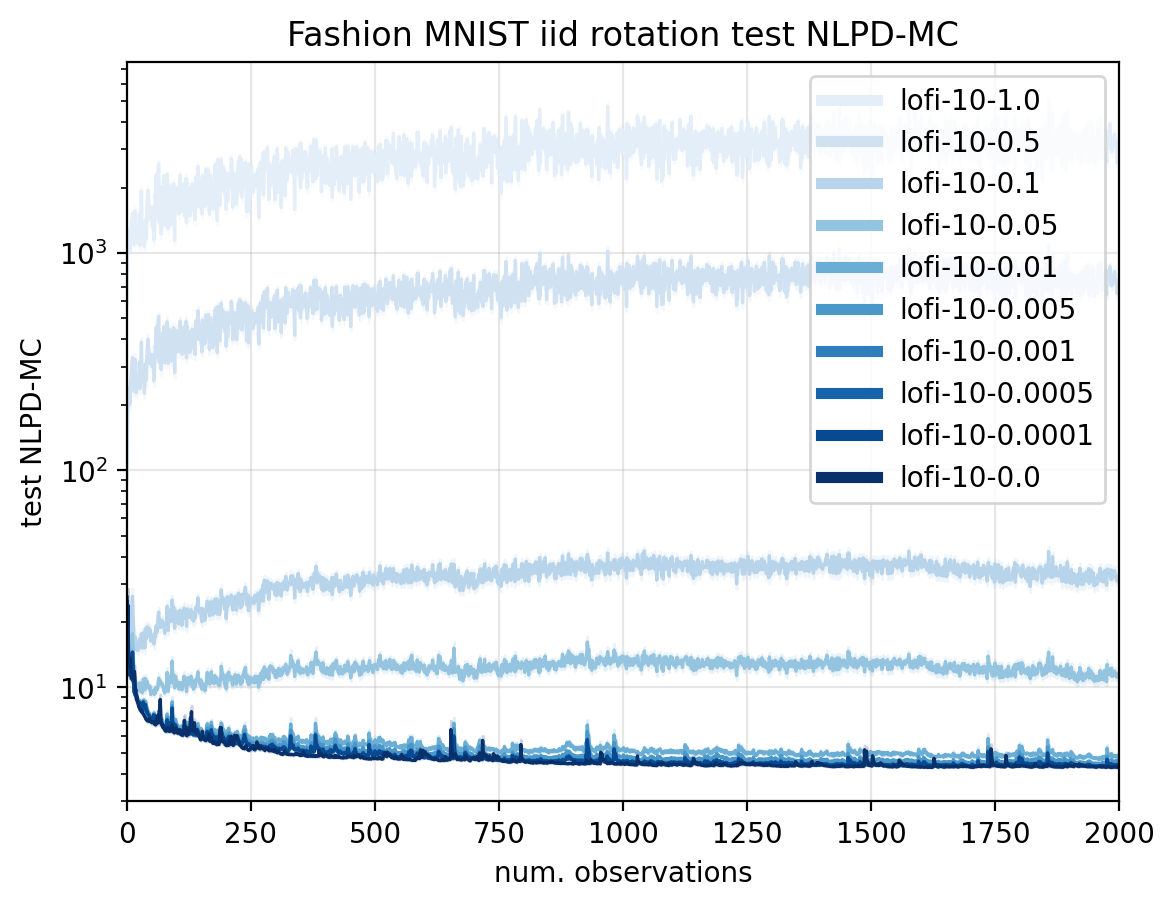

In [77]:
# NLPD-MC
fig, ax = plt.subplots()
for key, val in lofi_10_results_nlpd.items():
    mean, std = convolve(val['mean']), val['std']
    label, color, ls = methods_lofi_10[key]
    ax.plot(mean, label=label, c=color, linewidth=1.2, linestyle=ls)
    ax.fill_between(
        jnp.arange(mean.shape[0]),
        mean - std / jnp.sqrt(n_iter),
        mean + std / jnp.sqrt(n_iter),
        alpha=0.2,
        color=color
    )
ax.set_xlabel('num. observations')
ax.set_ylabel('test NLPD-MC')
ax.set_xlim(0, 2_000)
ax.set_yscale('log')
# ax.set_ylim(4.0, 20)
ax.grid(alpha=0.3)
ax.set_title('Fashion MNIST iid rotation test NLPD-MC')
leg = ax.legend()
# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(4.0)
# fig.savefig(Path(path_fmnist_mlp_nlpd, 'fmnist-mlp-reg-test-lofi1-nlpd-mc.pdf'), bbox_inches='tight')

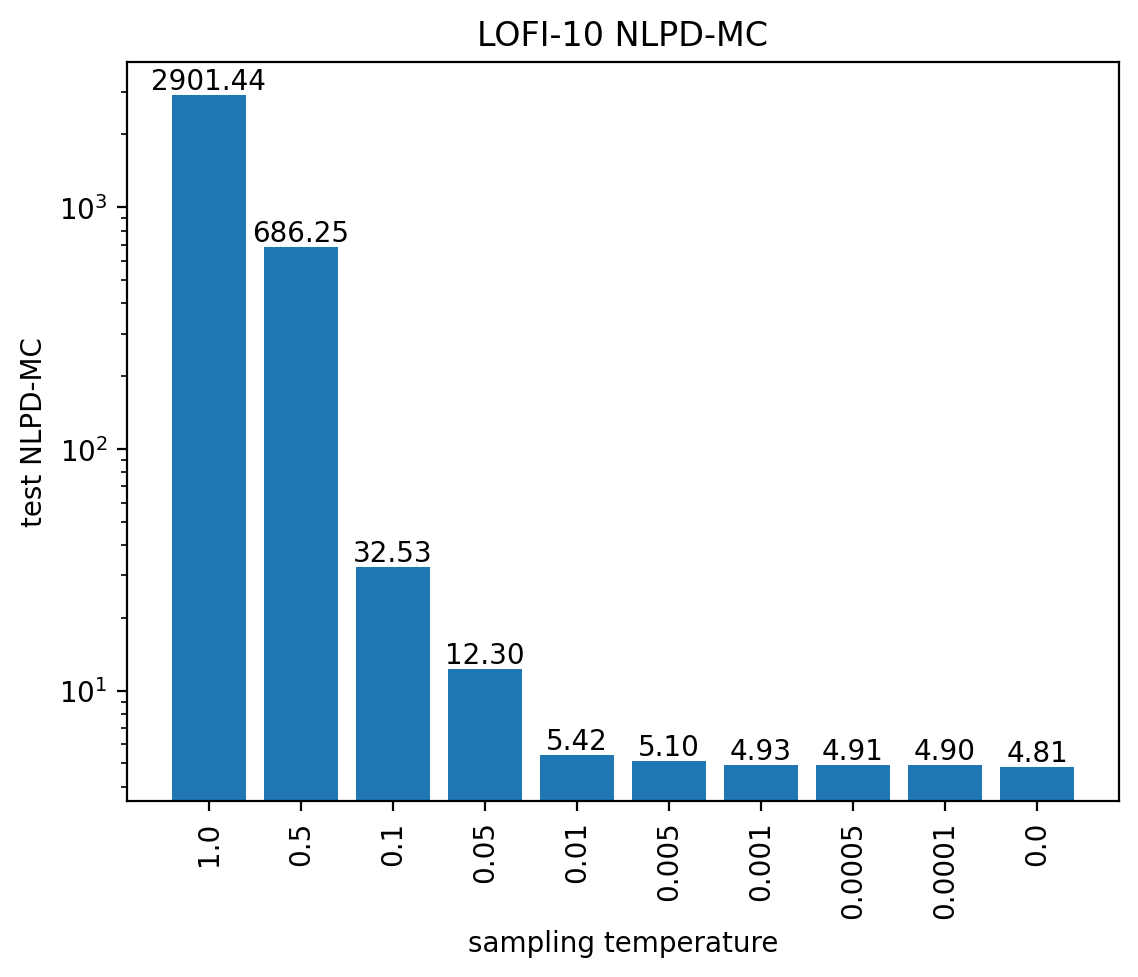

In [78]:
fig, ax = plt.subplots()
ax.bar(lofi_10_results_mean_nlpd.keys(), lofi_10_results_mean_nlpd.values());
ax.bar_label(ax.containers[0], fmt='%.2f', label_type='edge');
ax.set_yscale('log')
ax.set_ylabel('test NLPD-MC');
ax.set_xlabel('sampling temperature');
ax.set_title("LOFI-10 NLPD-MC")
plt.setp(ax.get_xticklabels(), fontsize=10, rotation='vertical');

NLPD Temperature Comparison (Using individually-tuned Hyperparams)

In [ ]:
# Set environmental va/run_regression_experiments.pyriables
%env REBAYES_OUTPUT=./iid-2000/f-mnist/mlp/nlpd-mc
%env REBAYES_CONFIG=../configs/

# Run the script
# To tune the hyperparameters:
%run run_regression_experiments.py --problem iid \
    --n_iter 20 --agents lofi --ranks 1 10 --temp 1.0 --nll_method nlpd-mc
%run run_regression_experiments.py --problem iid \
    --n_iter 20 --agents lofi --ranks 1 10 --temp 0.5 --nll_method nlpd-mc
%run run_regression_experiments.py --problem iid \
    --n_iter 20 --agents lofi --ranks 1 10 --temp 0.1 --nll_method nlpd-mc
%run run_regression_experiments.py --problem iid \
    --n_iter 20 --agents lofi --ranks 1 10 --temp 0.05 --nll_method nlpd-mc
%run run_regression_experiments.py --problem iid \
    --n_iter 20 --agents lofi --ranks 1 10 --temp 0.01 --nll_method nlpd-mc
%run run_regression_experiments.py --problem iid \
    --n_iter 20 --agents lofi --ranks 1 10 --temp 0.005 --nll_method nlpd-mc
%run run_regression_experiments.py --problem iid \
    --n_iter 20 --agents lofi --ranks 1 10 --temp 0.001 --nll_method nlpd-mc
%run run_regression_experiments.py --problem iid \
    --n_iter 20 --agents lofi --ranks 1 10 --temp 0.0005 --nll_method nlpd-mc
%run run_regression_experiments.py --problem iid \
    --n_iter 20 --agents lofi --ranks 1 10 --temp 0.0001 --nll_method nlpd-mc
%run run_regression_experiments.py --problem iid \
    --n_iter 20 --agents lofi --ranks 1 10 --temp 0.0 --nll_method nlpd-mc

In [83]:
methods_lofi_1 = {
    'lofi-1-temp-1.0': ('lofi-01-1.0', plt.cm.Blues(0.2), "-"),
    'lofi-1-temp-0.5': ('lofi-01-0.5', plt.cm.Blues(0.4), "-"),
    'lofi-1-temp-0.1': ('lofi-01-0.1', plt.cm.Blues(0.5), "-"),
    'lofi-1-temp-0.05': ('lofi-01-0.05', plt.cm.Blues(0.6), "-"),
    'lofi-1-temp-0.01': ('lofi-01-0.01', plt.cm.Blues(0.8), "-"),
    'lofi-1-temp-0.0': ('lofi-01-0.0', plt.cm.Blues(1.0), "-"),
}

n_iter = 20

In [93]:
path_fmnist_mlp_nlpd = Path(Path.cwd(), "iid-2000", "f-mnist", "mlp", "nlpd-mc")

lofi_1_fmnist_mlp_nlpd = (
    *[f"lofi-1-temp-{temp}" for temp in ['1.0', '0.5', '0.1',
                                         '0.05', '0.01', '0.0',]],
)

lofi_1_results_nlpd = {}
lofi_1_results_mean_nlpd = {}

for method in lofi_1_fmnist_mlp_nlpd:
    with open(Path(path_fmnist_mlp_nlpd, f'{method}.pkl'), "rb") as f:
        curr_result = pickle.load(f)

    key = "nlpd" if "nlpd" in curr_result else "nll"
    lofi_1_results_nlpd[method] = {
        "mean": jnp.mean(curr_result[key], axis=0),
        "std": jnp.std(curr_result[key], axis=0),
    }
    lofi_1_results_mean_nlpd[method.split("-")[-1]] = jnp.mean(curr_result[key])
        

In [94]:
kernel_size = 1
kernel = jnp.ones((kernel_size,)) / kernel_size
convolve = lambda x: jnp.convolve(x, kernel, mode='same')

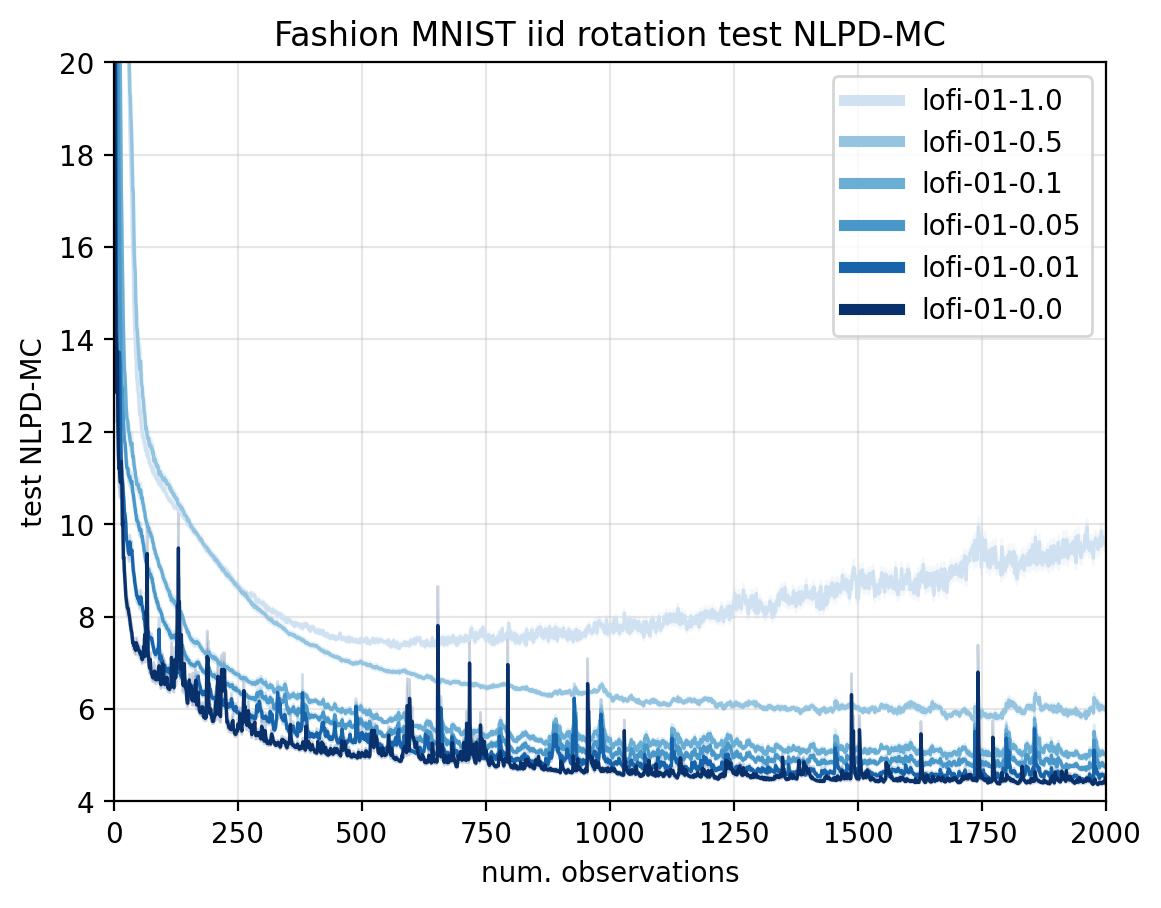

In [95]:
# NLPD-MC
fig, ax = plt.subplots()
for key, val in lofi_1_results_nlpd.items():
    mean, std = convolve(val['mean']), val['std']
    label, color, ls = methods_lofi_1[key]
    ax.plot(mean, label=label, c=color, linewidth=1.2, linestyle=ls)
    ax.fill_between(
        jnp.arange(mean.shape[0]),
        mean - std / jnp.sqrt(n_iter),
        mean + std / jnp.sqrt(n_iter),
        alpha=0.2,
        color=color
    )
ax.set_xlabel('num. observations')
ax.set_ylabel('test NLPD-MC')
ax.set_xlim(0, 2_000)
ax.set_ylim(4.0, 20)
ax.grid(alpha=0.3)
ax.set_title('Fashion MNIST iid rotation test NLPD-MC')
leg = ax.legend()
# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(4.0)
# fig.savefig(Path(path_fmnist_mlp_nlpd, 'fmnist-mlp-reg-test-lofi1-nlpd-mc.pdf'), bbox_inches='tight')

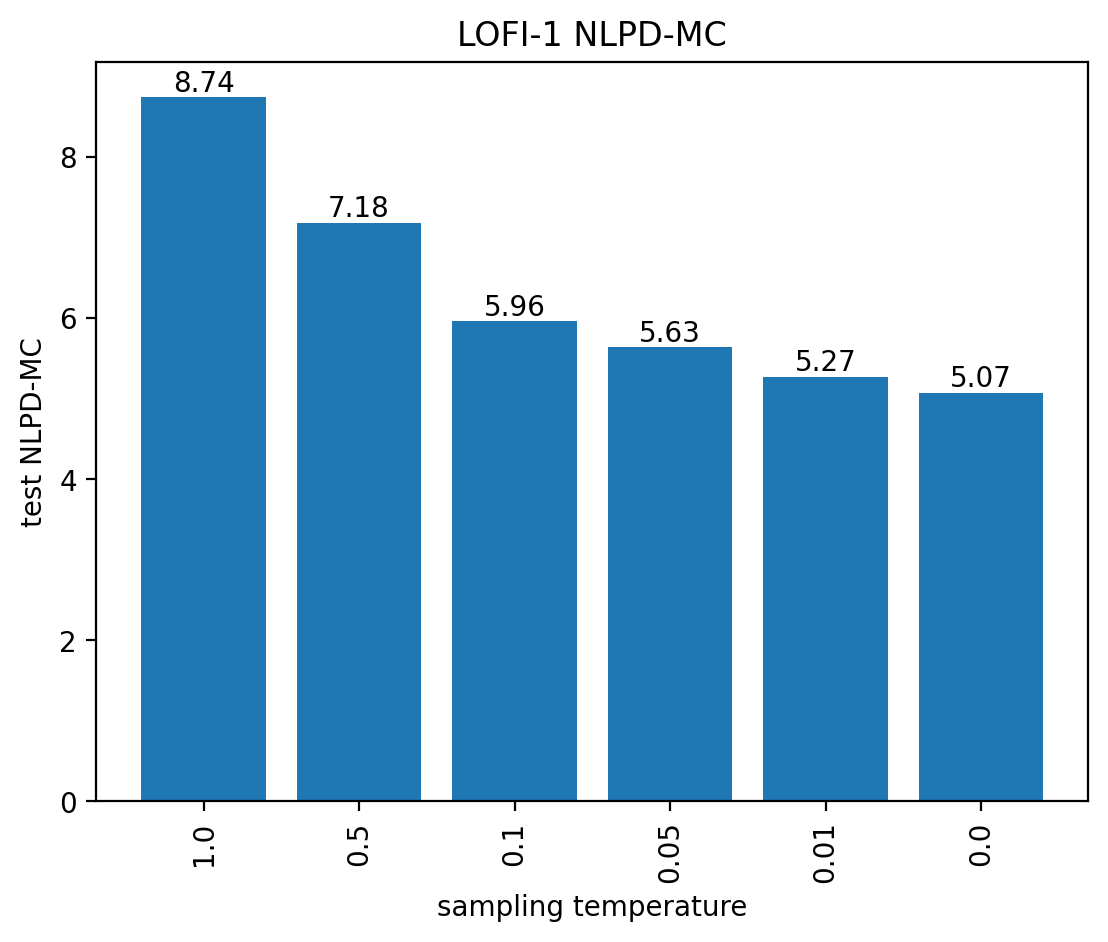

In [96]:
fig, ax = plt.subplots()
ax.bar(lofi_1_results_mean_nlpd.keys(), lofi_1_results_mean_nlpd.values());
ax.bar_label(ax.containers[0], fmt='%.2f', label_type='edge');
ax.set_ylabel('test NLPD-MC');
ax.set_xlabel('sampling temperature');
ax.set_title("LOFI-1 NLPD-MC")
plt.setp(ax.get_xticklabels(), fontsize=10, rotation='vertical');

NLPD-MC-Linearized with aleatoric factor = 0.0

In [126]:
path_fmnist_mlp = Path(Path.cwd(), "iid-2000", "f-mnist", "mlp", "nlpd-mc-linearized",
                       "aleatoric0.0")

agents_fmnist_mlp = (
    *[f"sgd-rb-{rank}" for rank in [1, 10,]],
    *[f"adam-rb-{rank}" for rank in [10,]],
    "fdekf", "vdekf",
    *[f"lofi-{rank}" for rank in [1, 10,]],
)

results_nlpd_fmnist_mlp = {}

for method in agents_fmnist_mlp:
    with open(Path(path_fmnist_mlp, f'{method}.pkl'), "rb") as f:
        curr_result = pickle.load(f)
    results_nlpd_fmnist_mlp[method] = {
        "mean": jnp.mean(curr_result["nlpd"], axis=0),
        "std": jnp.std(curr_result["nlpd"], axis=0),
    }

In [127]:
kernel_size = 10
kernel = jnp.ones((kernel_size,)) / kernel_size
convolve = lambda x: jnp.convolve(x, kernel, mode='same')

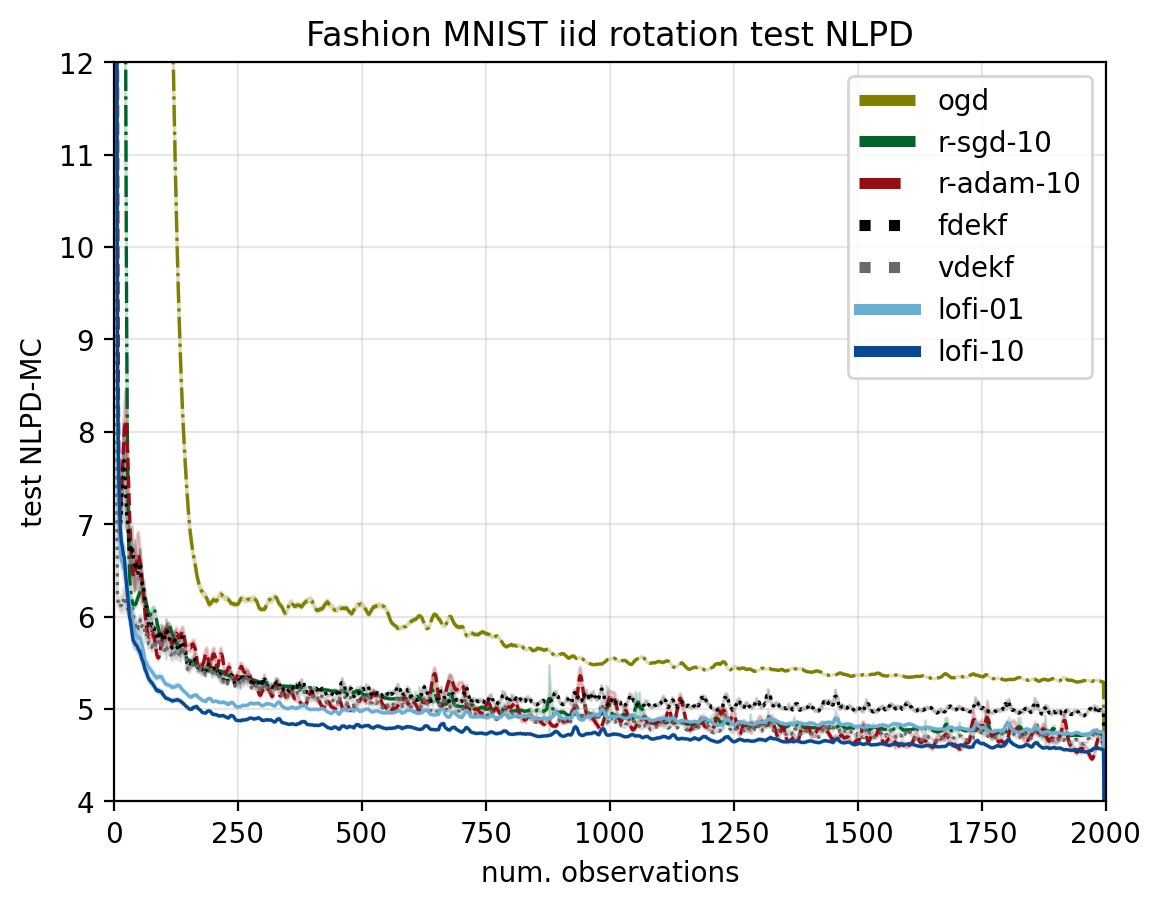

In [128]:
# NLPD-MC
fig, ax = plt.subplots()
for key, val in results_nlpd_fmnist_mlp.items():
    mean, std = convolve(val['mean']), val['std']
    label, color, ls = methods[key]
    ax.plot(mean, label=label, c=color, linewidth=1.2, linestyle=ls)
    ax.fill_between(
        jnp.arange(mean.shape[0]),
        mean - std / jnp.sqrt(n_iter),
        mean + std / jnp.sqrt(n_iter),
        alpha=0.2,
        color=color
    )
ax.set_xlabel('num. observations')
ax.set_ylabel('test NLPD-MC')
ax.set_xlim(0, 2_000)
ax.set_ylim(4.0, 12)
ax.grid(alpha=0.3)
ax.set_title('Fashion MNIST iid rotation test NLPD')
leg = ax.legend()
# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(4.0)

fig.savefig(Path(path_fmnist_mlp_nlpd, 'fmnist-mlp-reg-test-nlpd-mc.pdf'), bbox_inches='tight')

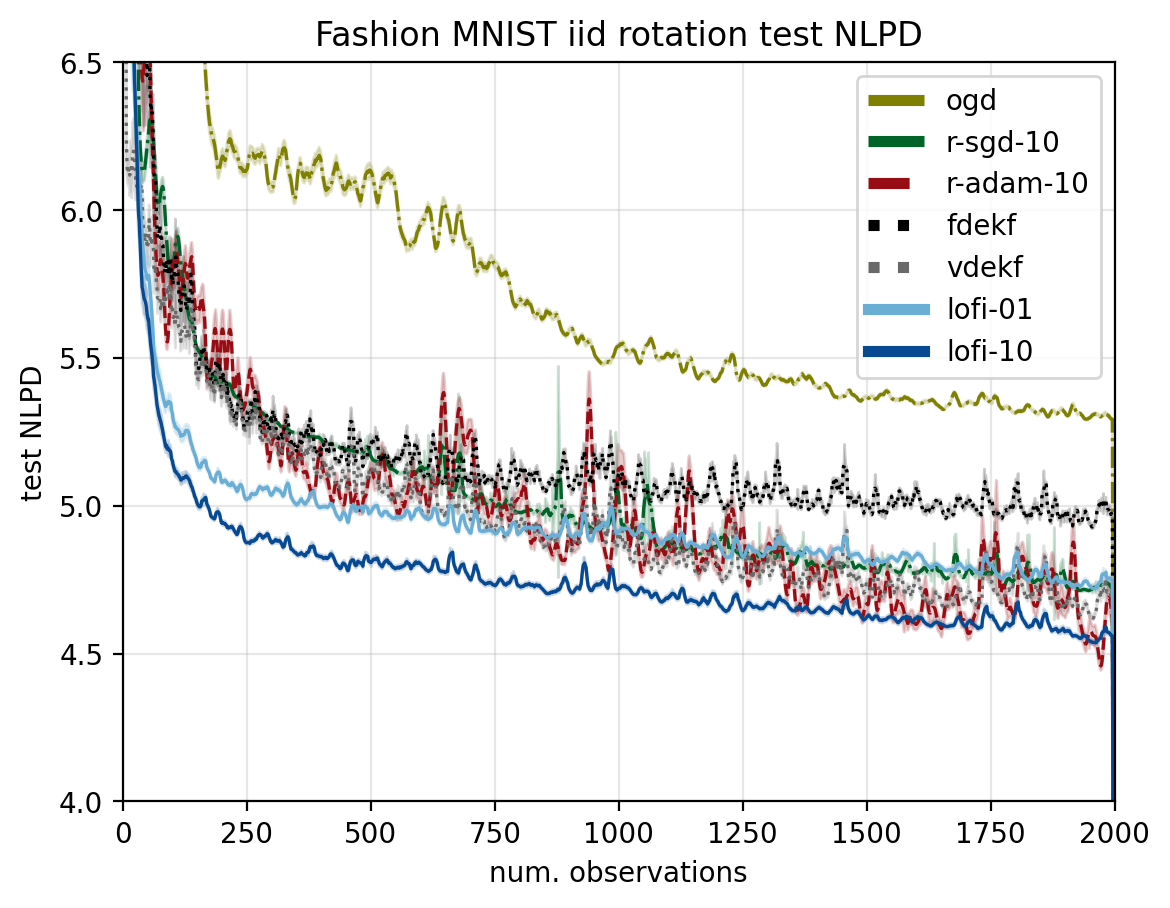

In [129]:
# NLPD-MC
fig, ax = plt.subplots()
for key, val in results_nlpd_fmnist_mlp.items():
    mean, std = convolve(val['mean']), val['std']
    label, color, ls = methods[key]
    ax.plot(mean, label=label, c=color, linewidth=1.2, linestyle=ls)
    ax.fill_between(
        jnp.arange(mean.shape[0]),
        mean - std / jnp.sqrt(n_iter),
        mean + std / jnp.sqrt(n_iter),
        alpha=0.2,
        color=color
    )
ax.set_xlabel('num. observations')
ax.set_ylabel('test NLPD')
ax.set_xlim(0, 2_000)
ax.set_ylim(4.0, 6.5)
ax.grid(alpha=0.3)
ax.set_title('Fashion MNIST iid rotation test NLPD')
leg = ax.legend()
# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(4.0)

fig.savefig(Path(path_fmnist_mlp_nlpd, 'fmnist-mlp-reg-test-nlpd-mc.pdf'), bbox_inches='tight')